# **Amazon sentiment analysis**

### By Richard Wang

# Data
The data is a sample of 982,619 reviews from the Amazon Kindle store.

Columns:
* `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* `asin` - ID of the product, e.g. 0000013714
* `reviewerName` - name of the reviewer
* `helpful` - helpfulness rating of the review, e.g. 2/3
* `reviewText` - text of the review
* `overall` - rating of the product
* `summary` - summary of the review
* `unixReviewTime` - time of the review (unix time)
* `reviewTime` - time of the review (raw)

## Aim:
The aim of this project is to analyse the sentiments of the reviews. This allows Amazon to find ways to enhance the quality of the Kindles and what customers like/dislike about their products. The project will aim to classify reviews into positive or negative tone based on textual content by training models. Through this process, we can gain insights into customer opinions toward the Kindle store.

## Process:
### 1. Prepare data and environment
In this step, I try to understand the data and do basic data cleaning, preparing for further analysis. This step also includes setting up the environment by importing relavant packages.

In [1]:
# Import necessary libraries for data processing and analysis
import pandas as pd
import string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# Load the dataset using pandas
data = pd.read_csv('review_Kindle_Store.csv')
# Display the first few rows of the dataset
data.head()
# Display information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      982619 non-null  object 
 1   asin            982619 non-null  object 
 2   reviewerName    978797 non-null  object 
 3   helpful         982619 non-null  object 
 4   reviewText      982597 non-null  object 
 5   overall         982619 non-null  float64
 6   summary         982500 non-null  object 
 7   unixReviewTime  982619 non-null  int64  
 8   reviewTime      982619 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 67.5+ MB


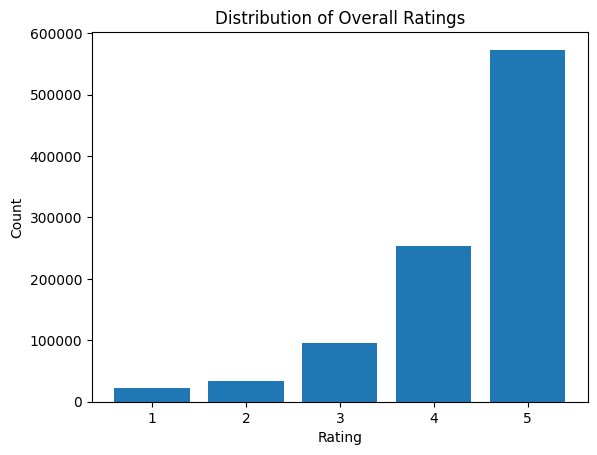

In [3]:
# Remove rows with missing values
data.dropna(inplace=True)

# Countring the number of each value in overal and sort the values based on the 'overall' rating
overall_counts = data['overall'].value_counts().sort_index()

# Plot the distribution of overall ratings
plt.bar(overall_counts.index, overall_counts.values)

# Customize the plot for better visualisation
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Overall Ratings')

# Display the plot
plt.show()

### 2. Further analysis
In this step I analyse the data further, preparing the data for modeling

In [4]:
# Define a set of stop words (basically words that are useless e.g. the, to, and, by etc.)
stop_words = set(stopwords.words('english'))
# Clean the 'reviewText' column by removing stop words
data['cleanReview'] = data['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Clean the 'summary' column by removing stop words
data['cleanSummary'] = data['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Ratings greater than 3 are considered positive (1), and the rest are considered negative (0)
# Amazon is a large company so, I believe having a rating of 3 would count as a 'bad review'
data['sentiment'] = data['overall'].apply(lambda rating: 1 if rating > 3 else 0) 

# Create a translator to remove punctuation
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation from the 'cleanReview' and 'cleanSummary' columns
data['cleanReview'] = data['cleanReview'].apply(lambda text: text.translate(translator))
data['cleanSummary'] = data['cleanSummary'].apply(lambda text: text.translate(translator))

**Note: For this step, I created word clouds to understand what kind of words were prominent within review or summary. This step allows me to understand the data more and helps with deciding what data I should model**

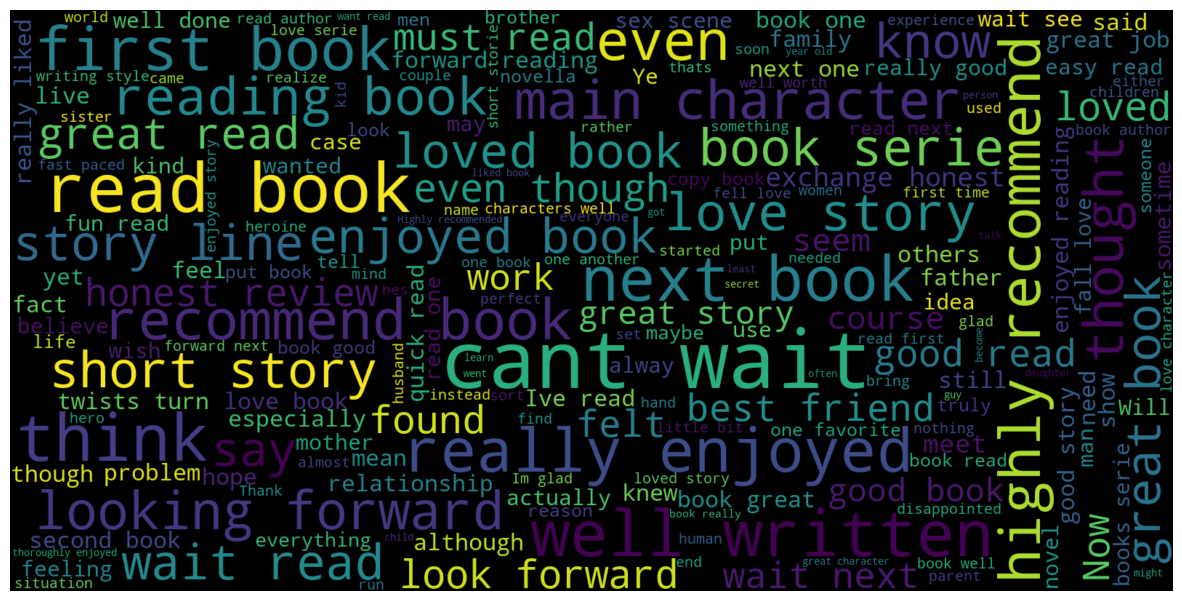

In [5]:
# Concatenate all positive review text into a single string
consolidated=' '.join(word for word in data['cleanReview'][data['sentiment']==1].astype(str))
# Create a WordCloud object with custom settings
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
# Create a plot to display the word cloud
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

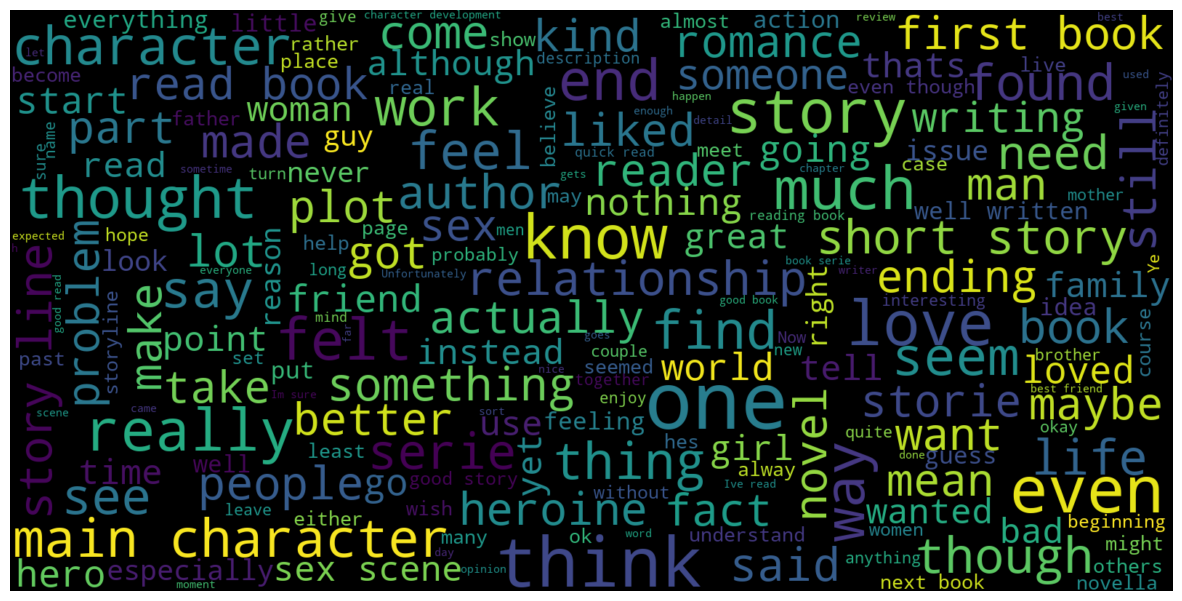

In [6]:
# Concatenate all negative review text into a single string
consolidated=' '.join(word for word in data['cleanReview'][data['sentiment']==0].astype(str))
# Create a WordCloud object with custom settings
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
# Create a plot to display the word cloud
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

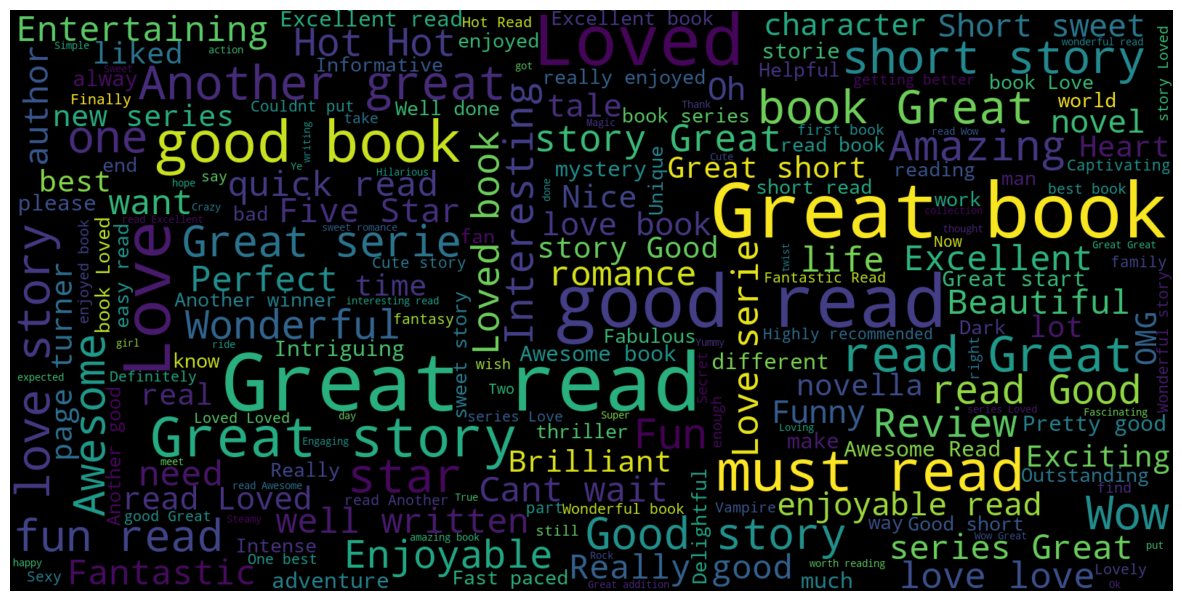

In [7]:
# Concatenate all positive summary text into a single string
consolidated=' '.join(word for word in data['cleanSummary'][data['sentiment']==1].astype(str))
# Create a WordCloud object with custom settings
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
# Create a plot to display the word cloud
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

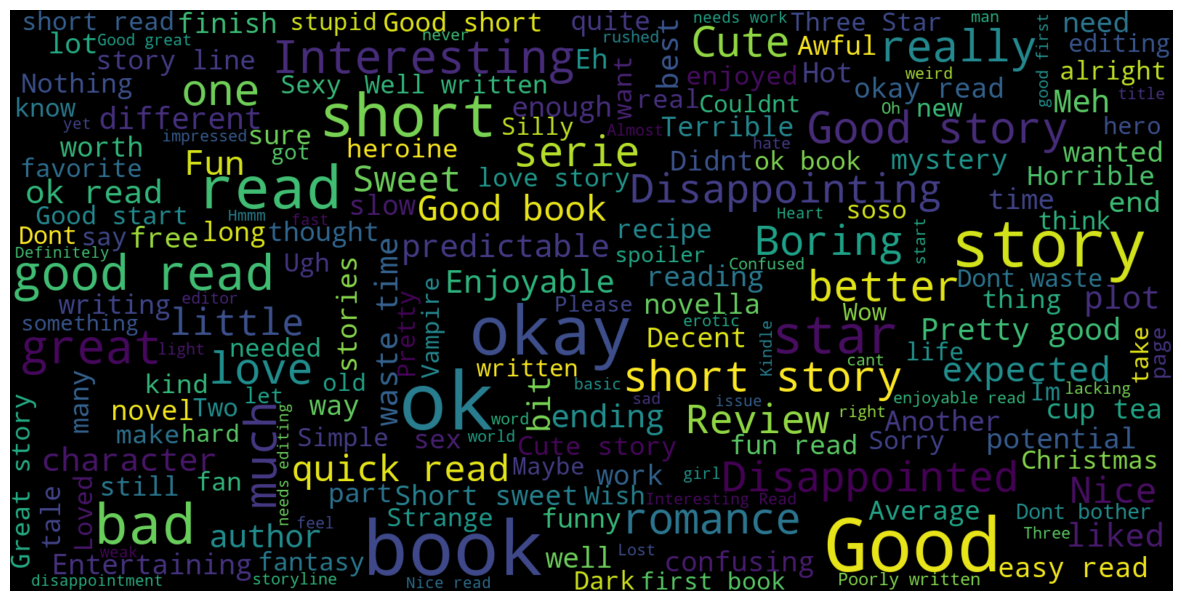

In [8]:
# Concatenate all negative summary text into a single string
consolidated=' '.join(word for word in data['cleanSummary'][data['sentiment']==0].astype(str))
# Create a WordCloud object with custom settings
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
# Create a plot to display the word cloud
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

**Note: From the word clouds created, it seems like most review tends to explore the story within the books rather than providing useful opinions about the book. On the other hand, there appears to be more emotive words in summary, which can be used to train the model.**

In [9]:
# Create a new DataFrame with the relavant 'cleanSummary' and 'sentiment' columns for model training
cleanData = data[['cleanSummary','sentiment']]
cleanData.head()

,cleanSummary,sentiment
0,Nice vintage story,1
1,Different,1
2,Oldie,1
3,I really liked it,1
4,Period Mystery,1


In [10]:
# Separate the feature and target variables
X = cleanData['cleanSummary']
y = cleanData['sentiment']

# Split the data into training and testing sets which is crusial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of CountVectorizer
# CountVectorizer converts a collection of text documents into a matrix of token counts
vectorizer = CountVectorizer()
# Transform the training data into a document-term matrix for model training
vect_X_train = vectorizer.fit_transform(X_train)
# Transform the testing data into a document-term matrix for model testing
vect_X_test = vectorizer.transform(X_test)

## 3. Creating/Training the model from the training datasets
In this step, logistic regression has been chosen for the model and there are many good reason to do so. Logistic regressions are great for solving classification problems (in this case classifying reviews based on negative or positive), they are easy to implement, interpret but most importantly very efficient to train which is required as this project has very limited time allocation.

In [ ]:
# Create an instance of LogisticRegression
model=LogisticRegression()
# Fit the model on the training data
model.fit(vect_X_train, y_train)
# Predict the sentiment for the testing data
y_predict = model.predict(vect_X_test)

## 4. Assessing the quality of the model
In this section, the model has been trained and is being tested with the test dataset, this allows for quality assessment to see how well the model works. “All models are wrong, but some are useful”

In [12]:
# Calculate the accuracy score
model_accuracy = accuracy_score(y_test,y_predict)
# Calculate the precision score
model_precision = precision_score(y_test,y_predict)
# Calculate the recall score
model_recall = recall_score(y_test,y_predict)
# Calculate the F1 score
model_f1 = f1_score(y_test, y_predict)
# Generate the classification report
model_report = classification_report(y_test, y_predict)

# Print out the scores of the model
print('Accuracy:')
print(model_accuracy)
print('Precision:')
print(model_precision)
print('Recall:')
print(model_recall)
print('F1 score:')
print(model_f1)
print('Report:')
print(model_report)

Accuracy:
0.8879130648028938
Precision:
0.8982914159223128
Recall:
0.9778885101384692
F1 score:
0.9364015062572292
Report:
              precision    recall  f1-score   support

           0       0.77      0.40      0.53     30569
           1       0.90      0.98      0.94    165163

    accuracy                           0.89    195732
   macro avg       0.83      0.69      0.73    195732
weighted avg       0.88      0.89      0.87    195732



**Overall, the model has a high accuracy and precision scores and incredibly high recall and f1 scores. The model is faily accurate at predicting sentiment reviews!**

In [13]:
# Calculate the confusion matrix
confusion_mx = confusion_matrix(y_test, y_predict)
print(confusion_mx) # Difficult to understand, so lets visualise this

[[ 12282  18287]
 [  3652 161511]]


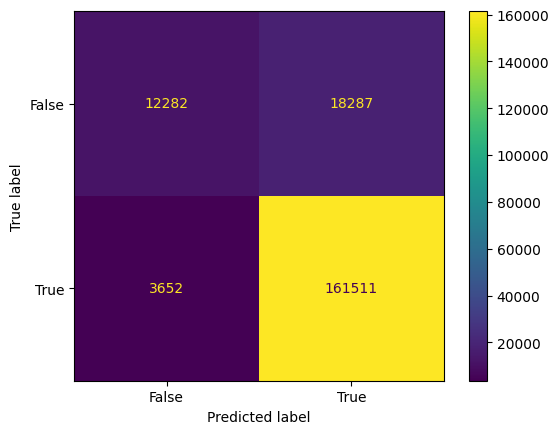

In [14]:
# Create a ConfusionMatrixDisplay object with the confusion matrix and display labels
mx_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_mx, display_labels=[False, True])
# Plot the confusion matrix
mx_plot.plot()
plt.show()

## Conclusion
In this data science project, my aim was to analyse and use a machine learning model with the Amazon Kindle reviews dataset. I employed a logistic regression model to predict sentiment based on the review texts.

After conducting data analysis and preprocessing, including handling missing values and cleaning the data, I successfully trained a logistic regression model using the review texts as features. The model demonstrated impressive accuracy in predicting sentiment reviews.

I assessed the quality of the model using several evaluation metrics, including accuracy, precision, recall, and F1 score. The accuracy metric revealed a high overall accuracy, indicating the model's effectiveness in correctly classifying positive and negative sentiment. The precision and recall scores further emphasized the model's ability to identify sentiment accurately. The F1 score provided a balanced measure of the model's performance, considering both precision and recall.

To gain insights from the data, I utilised visualisations such as bar graphs to depict the distribution of overall ratings and word clouds to visualise frequently occurring words in the review texts. These visualisations helped us understand the sentiment patterns and key themes within the reviews.

In conclusion, this project has demonstrated the potential of machine learning models, particularly logistic regression, in predicting sentiment based on Amazon Kindle reviews. The model achieved high accuracy and provided valuable insights into sentiment analysis. I am really happy with how the model turned out!